# Predicting electricity peak in Finland with Bayesian linear model 

## Abstract

Predicting future peak electricity demand of Finland has many factors where temperature plays a significant role. Finland's electricity demand has a high correlation with temperature because of high share of electrical heating. This report aims to study if historical minimum temperature data is still relevant for future temperature and therefore peak electricity demand prediction.

This study predicts the minimum temperature of four cities in Finland in 2030 using Gaussian Linear model and bayesian methods. The cities are Helsinki, Jyväskylä, Oulu and Rovaniemi. The analysis is based on historical minimum yearly temperature data between years 1980 - 2017 from the open data of Finnish meteorological Insitute.

This study shows that the yearly minimum temperatures are increasing in all of these 4 cities. The average rates of change of the temperature in these spots were between 0.03 ∘  and 0.09 ∘  Celsius per year which indicates that the historical temperatures are colder than the ones in the future.

# 1. Introduction
----

The aim for this study is to determine if there is a trend in temperature change in cities in Finland in the last 30 years. The motivation behind this is to see if electricity demand related to electricity heating will increase or decrease due to changes in minimum temperatures in Finland. The peak demand of electricity in Finland has a high correlation with the temperature of the day and the peak demand of electricity usually occurs during the coldest day of the year in the winter. The practical reason behind this is that colder temperature increases electicity demand due to electicity heating.

A simple way of predicting the future peak electricity demand is based on historical minimum temperatures of the year from the past 30-35 years and using it as a proxy for the future. This practice assumes that historical temperatures have a similar probability of occurring today as in the past. This assumption holds true if the changes in temperatures variate randomly but not if there is some kind of trend in the development of the minimum temperature of the year. This report aims to study if there is a trend in the change in the minimum temperature of the year in Finland.

This report uses bayesian linear model in order to determine if there is a change in minimum temperature of the year in Finland between 1980-2017. An increase in minimum temperature means lower estimation for future peak electricity demand and a decrease means higher estimation. The model is also used for predicting the minimum temperature of 2017 and 2030. We can use the prediction for 2017 as a check if our model is reasonable since we already have data for 2017. Year 2030 is the most interesting one to see what the model predicts for a bit more than 10 years from now.

Structure of the notebook is the following: First chapter gives the introduction to the motivation of this study and data used for this study. Second chapter describes methods for this study which includes discussion about the linear gaussian model, description of priors and Stan model.

Third chapter presents the main results which includes the predicted rate of change of temperature per year in Helsinki and posterior prediction for the minimum temperature in 2030. The chapter also shows the convergence diagnostics and that the results can be considered reliable through posterior predictive checking. It also compares the chosen model with a hierarchical linear gaussian model and shows why separate model was chosen.

Fourth chapter discusses the results, problems and potential improvements. Acknowledgements, sources and appendix can be found in the end of this report.

## 1.2 Description of data
----

The data consists of minimum temperatures of five measurement locations between 1980-2017 as shown below as a table. The data is based on API data from the meteorological insitute of Finland [1]. Four locations are used in order to see if the location has an affect on the result. The measurement locations are Helsinki, Jyväskylä, Oulu Hailuoto and Rovaniemi.

The chart below shows that there is clear variation of minimum temperatures between the years and between different locations. The chart also shows that the minimum temperature is colder in the north than in the south. However, we are interested in the change during the time period within a measurement location.

In [1]:
# Importing libaries
import csv
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('temperature_min.csv', sep=";", header=0)
d = df.values
print(df.head(5))

   Vuosi  Helsinki Kaisaniemi  Jyvaskyla lentoasema  Hailuoto Keskikyla  \
0   1980                -22.2                 -26.5               -27.4   
1   1981                -17.6                 -23.1               -26.4   
2   1982                -19.9                 -26.8               -28.8   
3   1983                -13.6                 -23.9               -26.9   
4   1984                -16.1                 -21.2               -24.8   

   Rovaniemi Apukka  
0             -36.0  
1             -37.5  
2             -38.3  
3             -34.1  
4             -29.2  


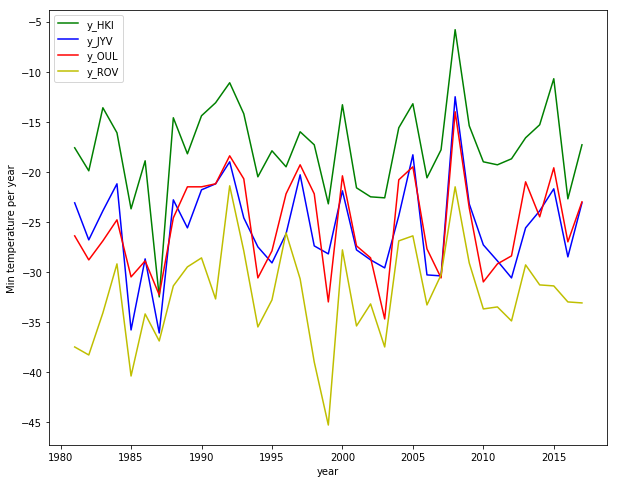

In [3]:
y_HKI = d[1:,1].astype(float)
y_JYV = d[1:,2].astype(float)
y_OUL = d[1:,3].astype(float)
y_ROV = d[1:,4].astype(float)
x_data = d[1:,0].astype(int)

plt.figure(figsize = (10,8))
plt.plot(x_data, y_HKI, color = 'g', label = 'y_HKI')
plt.plot(x_data, y_JYV, color = 'b', label = 'y_JYV')
plt.plot(x_data, y_OUL, color = 'r', label = 'y_OUL')
plt.plot(x_data, y_ROV, color = 'y', label = 'y_ROV')

plt.xlabel('year')
plt.ylabel('Min temperature per year');
plt.legend()

#### Figure 1. Visualisation of yearly minimum temperatures in Helsinki, Jyväskylä, Hailuoto and Rovaniemi



# 2. Method

## 2.1 Description of the model
---

This data analysis was done in two parts. First, we used a Gaussian linear model to predict the temperature's minimum peaks in Helsinki. Second, we validated the results by using the same model for different cities in Finland.

The first measurement spot is in Kaisaniemi, which lays in the center of Helsinki. It's location might result in small increase in temperature with the city around it growing and emitting more heat throughout the years. Also, as we have no information about the specific ways of measurements in this exact spot, there is reason to check if similar trends are found in other regions of Finland. Thus, we used the same linear model to predict temperatures' minimum peaks in three other spots: Jyväskylä, Hailuoto and Rovaniemi.

The predictions are drawn from normal distributions $$N(\mu,\sigma)$$ where, $$\mu = \alpha + \beta * predicted year$$
in which both $\alpha$ and $\beta$ are drawn from uniform distributions. 

## 2.2 Description of prior choices
---

We considered using similar priors for $\alpha$ and $\beta$ as in Kilpisjärvi demo [2]. The priors in this demo used weakly informative priors for $\alpha$ and $\beta$. However we decided to use uniform priors for all parameters, $\alpha$, $\beta$ and $\sigma$ to give stronger emphasis for the measured data. 

## 2.3 STAN Code
---

Below you can see the implemented STAN-model.

In [4]:
import pystan
import psis
import stan_utility

In [5]:
with open('temperature_lin.stan') as file:
    print(file.read())

//Original authors:
//Aki Vehtari, Tuomas Sivula

//Licence: CC-BY

// Comparison of k groups with common variance
data {
  int<lower=0> N; // number of data points
  vector[N] x; // year
  vector[N] y; // temperature
  real xpred; // predicted year
  real xpred2; // predicted year
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    real ypred2;
    vector[N] log_lik;
    ypred = normal_rng(alpha + beta*xpred, sigma);
    ypred2 = normal_rng(alpha + beta*xpred2, sigma);
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}


The model takes as input a vector "x" containing the years that were observed, temperature data vector "y" and the year we want to predict. This model works robustly with the data from other measurement spots or with different amount of datapoints. 

Xpred and xpred2 are the years we want to make the predictions for. In this report they are 2017 and 2030. We thought that these years were good choices since the prediction for 2017 can be compared to real data to validate the models sensibility. Prediction for 2030 should both be already giving notisable increase in the minimum temperatures, and same time predict the temperatures in a World that most likely has not yet changed significally.

The STAN-model will be run with 10 chains and 1000 samples per chain with warmup-length of 500 for every chain.

**Here we intialise the data, fit the linear gaussian model for each measurement location and extract samples that we can analyse later on. The models for Jyväskylä, Oulu and Rovaniemi are used later to validate the findings from the model used for Helsinki.**

In [54]:
x =  np.array(range(1980, 2018))
y_labels = ['Helsinki', 'Jyvaskyla', 'Oulu', 'Rovaniemi']
K = 1 # number of groups
y_label = y_labels[K-1]
y_hki = d[:, K:K+1].ravel()
N = len(y_hki)
data_hki = dict(
    N = N,
    x = x,  # year indicator
    y = y_hki,   # observations
    xpred = 2017, #predicted area
    xpred2 = 2030
)

K = 2 # number of groups
y_label = y_labels[K-1]
y_jyv = d[:, K:K+1].ravel()
data_jyv = dict(
    N = N,
    x = x,  # year indicator
    y = y_jyv,   # observations
    xpred = 2017, #predicted area
    xpred2 = 2030
)

K = 3 # number of groups
y_label = y_labels[K-1]
y_oul = d[:, K:K+1].ravel()
data_oul = dict(
    N = N,
    x = x,  # year indicator
    y = y_oul,   # observations
    xpred = 2017, #predicted area
    xpred2 = 2030
)

K = 4 # number of groups
y_label = y_labels[K-1]
y_rov = d[:, K:K+1].ravel()
data_rov = dict(
    N = N,
    x = x,  # year indicator
    y = y_rov,   # observations
    xpred = 2017, #predicted area
    xpred2 = 2030
)


In [34]:
# Linear gaussian model for minimum temperature in Helsinki
model_lin = stan_utility.compile_model('temperature_lin.stan')
fit_hki = model_lin.sampling(data=data_hki, seed=194838, iter=1000, chains = 10)
samples_hki = fit_hki.extract(permuted=True)

# Same model for the other meassurement locations
fit_jyv = model_lin.sampling(data=data_jyv, seed=194838, iter=1000, chains = 10)
samples_jyv = fit_jyv.extract(permuted=True)

fit_oul = model_lin.sampling(data=data_oul, seed=194838, iter=1000, chains = 10)
samples_oul = fit_oul.extract(permuted=True)

fit_rov = model_lin.sampling(data=data_rov, seed=194838, iter=1000, chains = 10)
samples_rov = fit_rov.extract(permuted=True)

Using cached StanModel


# 3. Results

## 3.1 Convergence diagnostics
----


With 10 Monte Carlo chains, 1000 iterations and using 500 for warm-up results in  R̂   value of close 1 which means that the model has converged. This means that we sampled enough and more sampling would not make a significant difference in the results.

Divergence and $n_{eff}$ are shown below.

In [35]:
stan_utility.check_div(fit_hki)

0.0 of 5000 iterations ended with a divergence (0.0%)


In [36]:
print(fit_hki)

Inference for Stan model: anon_model_ece6ba0c2e107134a2469da73deaf7ff.
10 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=5000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -154.7    3.87 142.33 -441.3 -245.9 -156.0 -61.93 138.79   1350   1.01
beta          0.07  1.9e-3   0.07  -0.08   0.02   0.07   0.11   0.21   1350   1.01
sigma         4.79    0.01   0.59    3.8   4.38   4.73   5.17   6.06   1737    1.0
mu[1]       -18.99    0.04   1.53  -22.0  -20.0 -18.99 -17.96 -15.91   1699    1.0
mu[2]       -18.92    0.04   1.47  -21.8  -19.9 -18.92 -17.94 -15.96   1735    1.0
mu[3]       -18.85    0.03   1.41 -21.63 -19.79 -18.85  -17.9 -16.03   1777    1.0
mu[4]       -18.78    0.03   1.35 -21.42 -19.69 -18.79 -17.87 -16.09   1826    1.0
mu[5]       -18.72    0.03   1.29 -21.23 -19.57 -18.71 -17.84 -16.15   1884    1.0
mu[6]       -18.65    0.03   1.24 -21.07 -19.47 -18.65 -17.82 -16

## 3.2 Posterior predictive checking
---
Our model estimated the posterior prediction for the minimum temperature in Helsinki in 2017 and 2030. The predictions were:
- 2017: -16.4$^\circ$
- 2030: -15.5$^\circ$

The mean posterior prediction for $\beta$ = 0.07. $\beta$ describes the mean increase in minimum temperature in Helsinki in $^\circ$/year.
We also wanted to know how certain are we that minimum temperature is increasing in Helsinki which is:
$P(\beta > 0) \approx 85$ %. 

Samples from the posterior distribution are shown in charts below for beta and predictions for 2017 and 2030. The historical value for the minimum temperature in Helsinki in 2017 was -17.3$^\circ$ which is actually quite close to the posterior prediction. Also, the 95% confidence interval of the posterior distribution is between -26 and -6.6 degrees which seems reasonable.

In [37]:
print('Helsinki Pr(beta > 0.0) = {}'.format(np.mean(samples_hki['beta'] > 0.0)))
print('Helsinki Pr(beta) = {}'.format(np.mean(samples_hki['beta'])))

Helsinki Pr(beta > 0.0) = 0.8414
Helsinki Pr(beta) = 0.06857115751748523


In [53]:
def plot_posterior(samples, y, y_label):

    # make slightly wider figure of 3 plots
    figsize = plt.rcParams['figure.figsize'].copy()
    figsize[0] *= 1.4  # width
    figsize[1] *= 2.5  # height
    fig, axes = plt.subplots(4, 1, figsize=figsize)

    # plot 1: scatterplot and lines
    color_scatter = 'C0'  # 'C0' for default color #0
    color_line = 'C1'     # 'C1' for default color #1
    # lighten color_line
    color_shade = (
        1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
    )
    # plot
    ax = axes[0]
    ax.fill_between(
        x,
        np.percentile(samples['mu'], 2.5, axis=0),
        np.percentile(samples['mu'], 97.5, axis=0),
        color=color_shade
    )
    ax.plot(
        x,
        np.percentile(samples['mu'], 50, axis=0),
        color=color_line,
        linewidth=1
    )

    ax.plot(x,y)

    ax.scatter(x, y, 5, color=color_scatter)
    ax.set_xlabel('year')
    ax.set_ylabel('Winter lowest temperature at {}' .format(y_label))
    ax.set_xlim((1980, 2017))

    # plot 2: histogram
    ax = axes[1]
    ax.hist(samples['beta'], 50)
    ax.set_xlabel('beta')

    # plot 3: histogram
    ax = axes[2]
    ax.hist(samples['ypred'], 50)
    ax.set_xlabel('y-prediction for x={}'.format(2017))

    # plot 4: histogram
    ax = axes[3]
    ax.hist(samples['ypred2'], 50)
    ax.set_xlabel('y-prediction for x={}'.format(2030))

    # make figure compact
    fig.tight_layout();

<Figure size 432x288 with 0 Axes>

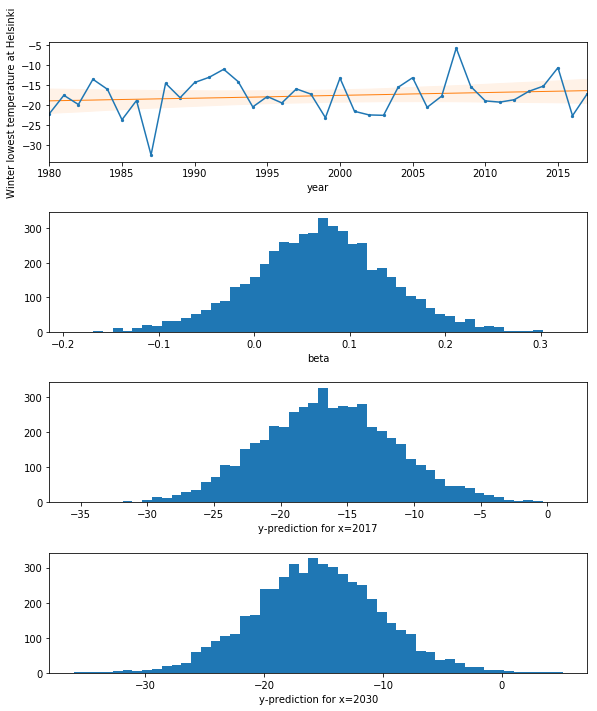

In [55]:
samples_list = [samples_hki]
y_list = [y_hki]
y_labels = ['Helsinki']
plot_number = 0
for sample in samples_list:
    samples = sample
    y_ = y_list[plot_number]
    y_label = y_labels[plot_number]
    plt.figure(plot_number)
    plot_posterior(samples, y_, y_label)
    plot_number += 1
    

#### Figure 2. Posterior temperature distribution, Posterior distribution of beta and posterior predictive distributions of minimum temperature in 2017 and 2030

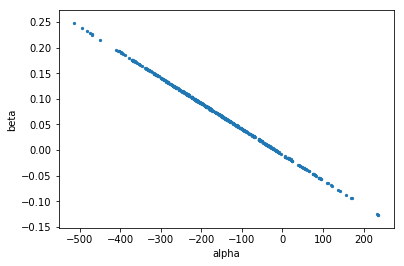

In [40]:
# preview 500 posterior samples of (alpha, beta)
plt.scatter(samples_hki['alpha'][:500], samples_hki['beta'][:500], 5)
plt.xlabel('alpha')
plt.ylabel('beta');

## 3.3 Sensitivity analysis
---

We also wanted to validate how the posterior prediction of the change in minimum temperature, $P(\beta > 0) \approx 85$ % for Helsinki compares with the other cities in Finland.

- Jyväskylä: $P(\beta > 0) \approx 66$ %. 
- Oulu: $P(\beta > 0) \approx 78$ %. 
- Rovaniemi: $P(\beta > 0) \approx 90$ %. 

We can see that there is some variance in the average increase in temperature between the cities which is quite normal. It seems that the northest cities show a more probable change in temperature. However, all measurement locations show similar trend that the minimum temperature is increasing.

The average change in temperatures in the cities were:
- Helsinki: $\beta$ = 0.07
- Jyväskylä: $\beta$ = 0.03
- Oulu: $\beta$ = 0.06
- Rovaniemi: $\beta$ = 0.09

The average change in yearly temperature seems to be strongest in Rovaniemi which is almost 1 degree / 10 years and lowest in Jyväskylä which is 0.3 degrees / 10 years. Helsinki and Oulu show similar change of about 0.6-0.7 degrees / 10 years. 

However all these results seem reasonable and the model works for different datasets without being too sensitive to changes in the location of the measured city..

In [41]:
print('Helsinki Pr(beta > 0.0) = {}'.format(np.mean(samples_hki['beta'] > 0.0)))
print('Jyväskylä Pr(beta > 0.0) = {}'.format(np.mean(samples_jyv['beta'] > 0.0)))
print('Oulu Pr(beta > 0.0) = {}'.format(np.mean(samples_oul['beta'] > 0.0)))
print('Rovaniemi Pr(beta > 0.0) = {}'.format(np.mean(samples_rov['beta'] > 0.0)))

print('Helsinki Pr(beta) = {}'.format(np.mean(samples_hki['beta'])))
print('Jyväskylä Pr(beta) = {}'.format(np.mean(samples_jyv['beta'])))
print('Oulu Pr(beta) = {}'.format(np.mean(samples_oul['beta'])))
print('Rovaniemi Pr(beta) = {}'.format(np.mean(samples_rov['beta'])))

Helsinki Pr(beta > 0.0) = 0.8414
Jyväskylä Pr(beta > 0.0) = 0.6478
Oulu Pr(beta > 0.0) = 0.791
Rovaniemi Pr(beta > 0.0) = 0.8978
Helsinki Pr(beta) = 0.06857115751748523
Jyväskylä Pr(beta) = 0.02570605713758065
Oulu Pr(beta) = 0.058044306808335264
Rovaniemi Pr(beta) = 0.09189831083884199


## 3.4 Model comparison with hierarchical linear gaussian model
---

The LOO-CV validation shows how accurately the predictive model performs. The model with the highest PSIS-LOO value indicates accurate predictive performance. In this project, our separate model shows higher PSIS-LOO value than our hierarchical model.


Seprate mode.:
- LOO-CV: -115 and
- Effective number of parameters is 12.

Hierarchical model:
- LOO-CV: -118 and
- Effective number of parameters is 8.

The reason behind why separate model works the best is quite practical. The data points are measured in different parts of Finland and which means that each measurement location should be analysed separately. Comparing measured temperatures in Helsinki and Rovaniemi does not make sense when trying to find out a trend in temperature change, even though the hierarchical model only uses a common variance but it still has a negative influence on the performance of the model.

We also plotted the k-values for the model. If all the values are below 0.7, "the PSIS-LOO estimate can be considered to be reliable, otherwise there is a concern that it may be biased (too optimistic, overestimating the predictive accuracy of the model)". 

The bar chart for separate model shows that one value is close to 0.7, one value close to 0.4 and all other values are clearly less than 0.4. This means that we can consider the PSIS-LOO estimate reliable.

Also the bar chart for the hierarchical model shows values close to 0 which means that the PSIS-LOO estimate can be considered reliable.

In [42]:
with open('lin_hier.stan') as file:
    print(file.read())

// Gaussian linear model with standardized data
data {
  int<lower=0> N; // number of data points #38
  vector[N] x; //years
  vector[N] y_HKI; // #38
  vector[N] y_JYV; // #38
  vector[N] y_HAI; // #38
  vector[N] y_OUL; // #38
  int<lower=0> M;
  vector[M] y_ALL;//
  
  real xpred; // input location for prediction
}
transformed data {
  vector[N] x_std;
  vector[N] y_HKIstd;
  vector[N] y_JYVstd;
  vector[N] y_HAIstd;
  vector[N] y_OULstd;
  real xpred_std;
  x_std = (x - mean(x)) / sd(x);
  y_HKIstd = (y_HKI - mean(y_HKI)) / sd(y_HKI);
  y_JYVstd = (y_JYV - mean(y_JYV)) / sd(y_JYV);
  y_HAIstd = (y_HAI - mean(y_HAI)) / sd(y_HAI);
  y_OULstd = (y_OUL - mean(y_OUL)) / sd(y_OUL);
  xpred_std = (xpred - mean(x)) / sd(x);
}
parameters {
  real alpha_HKI;
  real alpha_JYV;
  real alpha_HAI;
  real alpha_OUL;
  real beta_HKI;
  real beta_JYV;
  real beta_HAI;
  real beta_OUL;
  real<lower=0> sigma_std;
}
transformed parameters {
  vector[N] mu_HKIstd;
  vector[N] mu_JYVstd;
  vector[N] mu_

In [43]:
b = pd.read_csv('temperature_min.csv', sep=";", header=None)

temp = np.asarray(b)[:,:]
#print(temp)
x = temp[1:,0].astype(int)
y_HKI = temp[1:,1].astype(float)
y_JYV = temp[1:,2].astype(float)
y_HAI = temp[1:,3].astype(float)
y_ROV = temp[1:,4].astype(float)
y_ALL = temp[1:,1:].astype(float)
y_ALL = y_ALL.flatten()
M = len(y_ALL)
N = len(x)

data_hier = dict(
        N=38,
        x=x,
        y_HKI = y_HKI,
        y_JYV = y_JYV,
        y_HAI = y_HAI,
        y_OUL = y_ROV,
        y_ALL = y_ALL,
        M = M,
        xpred = 2017)

In [44]:
model_hier = stan_utility.compile_model('lin_hier.stan')
fit_hier = model_hier.sampling(data=data_hier, seed=194838, iter=1000, chains = 10)
samples_hier = fit_hier.extract(permuted=True)


Using cached StanModel


In [45]:
print('Helsinki Pr(beta > 0.0) = {}'.format(np.mean(samples_hier['beta_HKI'] > 0.0)))
print('Helsinki Pr(beta) = {}'.format(np.mean(samples_hier['beta_HKI'])))

Helsinki Pr(beta > 0.0) = 0.8326
Helsinki Pr(beta) = 0.15998068186836512


LOO-CV for separate linear model in Helsinki is -114.57589198626624
Effective number of paratemeters for separate linear model is 11.8617945513396


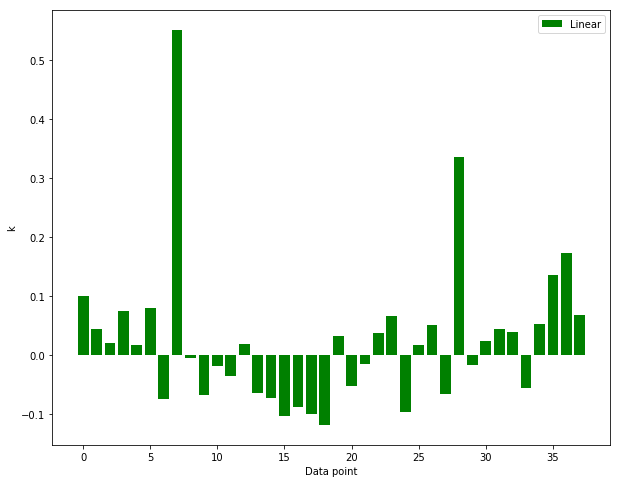

In [49]:
loo_lin, loos_lin, ks_lin = psis.psisloo(samples_hki["log_lik"])
print('LOO-CV for separate linear model in Helsinki is', loo_lin)

computed_lppd = np.sum(np.log(np.sum(np.exp(samples_hki["log_lik"]),axis=0)/4000))
pf_lin = computed_lppd - loo_lin
print('Effective number of paratemeters for separate linear model is',pf_lin)

fig, ax = plt.subplots(1, 1, figsize = (10,8))
x_ = range(0,38)
plt.bar(x_, ks_lin, color = 'g', label = 'Linear')
ax.set_xlabel('Data point')
ax.set_ylabel('k')
plt.legend()
plt.show()

**Figure 1. Visualisation of yearly minimum temperatures in Helsinki, Jyväskylä, Hailuoto and Rovaniemi**
**Figure 2. Posterior temperature distribution, Posterior distribution of beta and posterior predictive distributions of minimum temperature in 2017 and 2030**
**Figure 3. Posterior distribution of alpha and beta**
**Figure 4. Chart showing K-values separate linear model in Helsinki**
**Figure 5. K-values of hierarchical model**

LOO-CV for hierachical linear model in Helsinki is -117.61566176250882
LOO-CV for hierarchical linear model in Helsinki is -117.61566176250882
Effective number of paratemeters for hierarchical linear model is 8.963563777839369


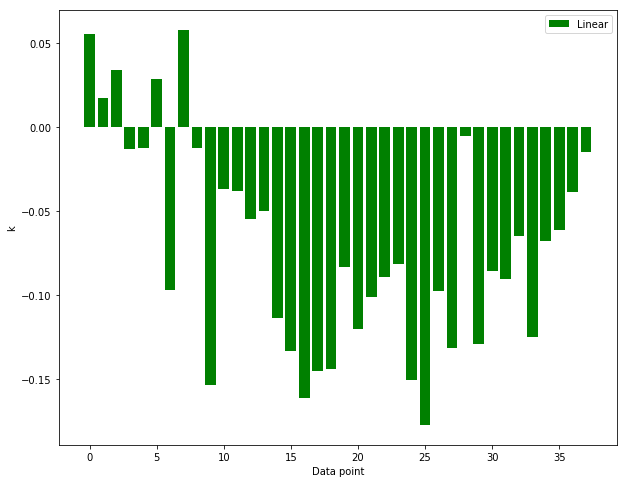

In [50]:
loo_lin, loos_lin, ks_lin = psis.psisloo(samples_hier["log_likHKI"])
print('LOO-CV for hierachical linear model in Helsinki is', loo_lin)

loo_lin, loos_lin, ks_lin = psis.psisloo(samples_hier["log_likHKI"])
print('LOO-CV for hierarchical linear model in Helsinki is', loo_lin)

computed_lppd = np.sum(np.log(np.sum(np.exp(samples_hier["log_likHKI"]),axis=0)/4000))
pf_lin = computed_lppd - loo_lin
print('Effective number of paratemeters for hierarchical linear model is',pf_lin)

fig, ax = plt.subplots(1, 1, figsize = (10,8))
x_ = range(0,38)
plt.bar(x, ks_lin, color = 'g', label = 'Linear')
ax.set_xlabel('Data point')
ax.set_ylabel('k')
plt.legend()
plt.show()

# 4. Discussion
---

The aim for this study was to determine if there is a trend in temperature change in cities in Finland in the last 30 years. This study shows that the minimum temperature of the year is increasing. This means that the coldest period of the winter is warming up which leads to lower electricity demand due to electricity heating.

Our separate linear gaussian model posterior prediction showed that the probability of temperature increasing in Helsinki is 85 % and the mean temperature change per year is 0.07$^\circ$ per year. This means that during the last 30 years the minimum temperature has warmed up by 2.1 degrees. We performed sensitivity analyses from temperature data from Jyväskylä, Oulu and Rovaniemi which all confirm the findings that the minimum temperature of the year has increased. The rate of temperature change varied between 0.03$^\circ$ - 0.09$^\circ$ per year depending on city. This means a predicted change of 0.9$^\circ$ - 2.7$^\circ$ in 30 years. These findings indicate that historical temperatures are colder than the ones in the future. 

WE consider the results quite reliable.
- Convergence checking showed that our model converged and more samples would not have changed the results.

- Posterior predictive checking with PSIS-LOO values showed that the results can be considered reliable.

- We fitted the data also with a hierarchical model but it seemed to perform worse than separate model. This is due to the fact that measurement data from different locations should not have a common variance nor a common mean. This is why separate linear gaussian model is the right way to analyse this problem.

Even though the model is reliable, there is still room for improvement. The model used unstandardised data where the x -values were far from 0. High x-values led to strong posterior linear correlation between alpha and beta, which resulted in warnings stating that roughly 20% percent of iterations saturated at maximum tree-depth while fitting the STAN-model. This does not invalidate our results, but could be fixed if there was more time.

# 5. Acknowledgements
---

** Gaussian linear STAN mode based on**

Original authors: Aki Vehtari, Tuomas Sivula

Licence: CC-BY

**Stan utilities libary**

Copyright: Michael Betancourt <https://betanalpha.github.io/writing/>

License: BSD (3 clause)

See also http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html



# Sources and Appendix

[1] Finnish meteorological institute. Open Data. https://ilmatieteenlaitos.fi/havaintojen-lataus#!/

[2] Gaussian linear model with adjustable priors. Aki Vehtari, Tuomas Sivula. https://github.com/avehtari/BDA_py_demos/blob/master/demos_pystan/pystan_demo.ipynb

# Appendix 1: Posterior prediction distributions for separate linear gaussian model for Jyväskylä, Oulu and Rovaniemi

<Figure size 432x288 with 0 Axes>

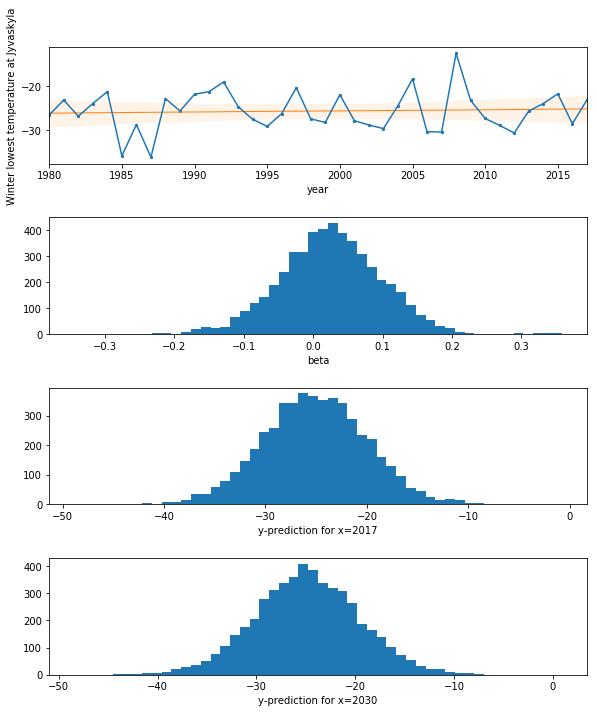

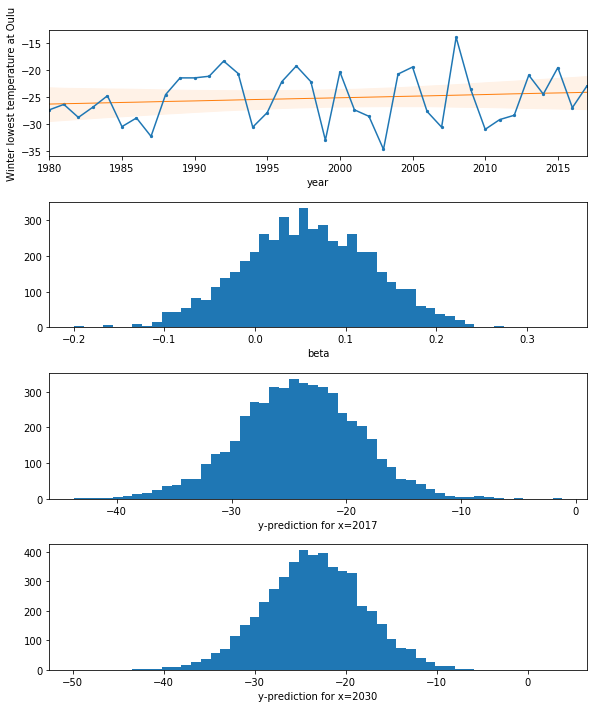

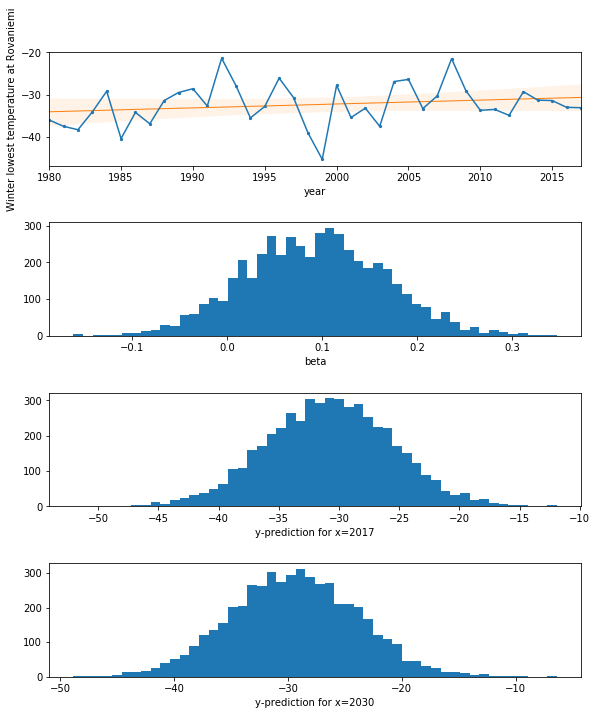

In [56]:
samples_list = [samples_jyv, samples_oul, samples_rov]
y_list = [y_jyv, y_oul, y_rov]
y_labels = ['Jyvaskyla', 'Oulu', 'Rovaniemi']
plot_number = 0
for sample in samples_list:
    samples = sample
    y_label = y_labels[plot_number]
    y = y_list[plot_number]
    plt.figure(plot_number)
    plot_posterior(samples, y, y_label)
    plot_number += 1